This notebook supports the equations that govern contaminant uptake and impacts on the biology within the Salish Sea Atlantis model. It shows the 1-day output of simulations after injecting PAH components of oil into the water column, to observe biological uptake, as well as non-lethal and lethal impacts relative to a control simulation with no contaminants injected.

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [1]:
import os
import re
import xarray as xr
import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [2]:
# Read in salish sea atlantis output files.
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/highres-control-3y/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])

In [3]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')
scenario_paths = sorted([p for p in scenario_root.glob('highres-scenario_*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[2]])

highres-scenario_4a_2019-07-04 low Fraser flow, summer spring tide
highres-scenario_4a_2019-07-10 low Fraser flow, summer neap tide
highres-scenario_4a_2020-07-12 high Fraser flow, summer neap tide
highres-scenario_4a_2020-07-22 high Fraser flow, summer spring tide
highres-scenario_5b_2019-01-14 low Fraser flow, winter neap tide
highres-scenario_5b_2019-01-20 low Fraser flow, winter spring tide
highres-scenario_5b_2020-01-16 high Fraser flow, winter neap tide
highres-scenario_5b_2020-01-24 high Fraser flow, winter spring tide
highres-scenario_6a_2019-07-16 low Fraser flow, summer spring tide
highres-scenario_6a_2019-07-25 low Fraser flow, summer neap tide
highres-scenario_6a_2020-07-13 high Fraser flow, summer neap tide
highres-scenario_6a_2020-07-21 high Fraser flow, summer spring tide
highres-scenario_7a_2019-01-21 low Fraser flow, winter spring tide
highres-scenario_7a_2019-01-26 low Fraser flow, winter neap tide
highres-scenario_7a_2020-01-03 high Fraser flow, winter neap tide
high

In [4]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [5]:
start = 0
end = time.size-1

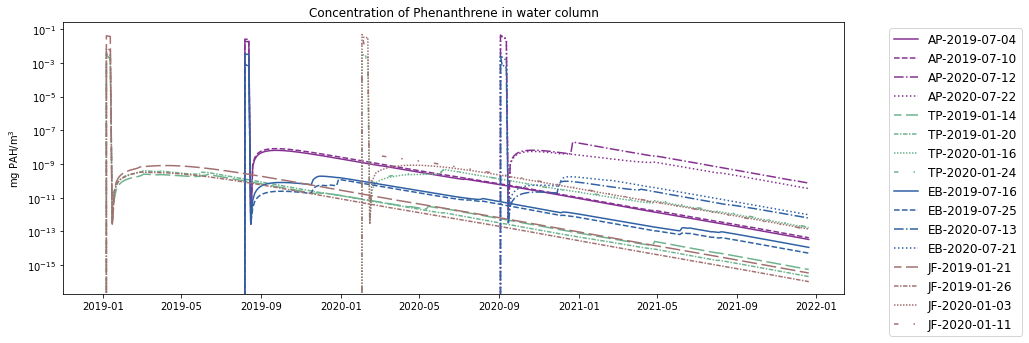

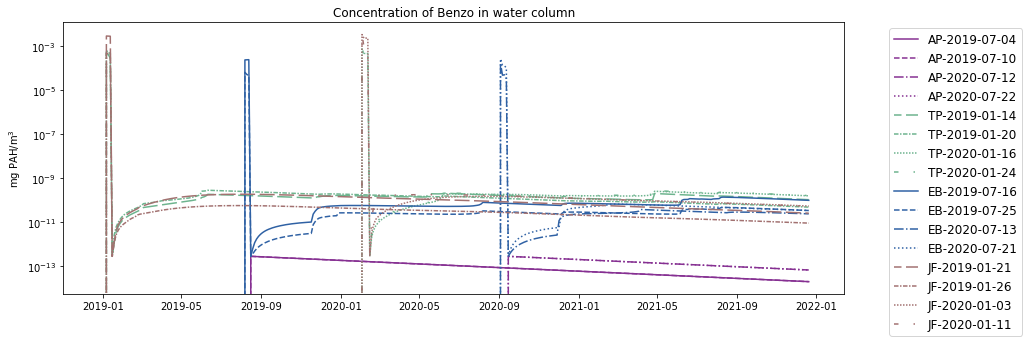

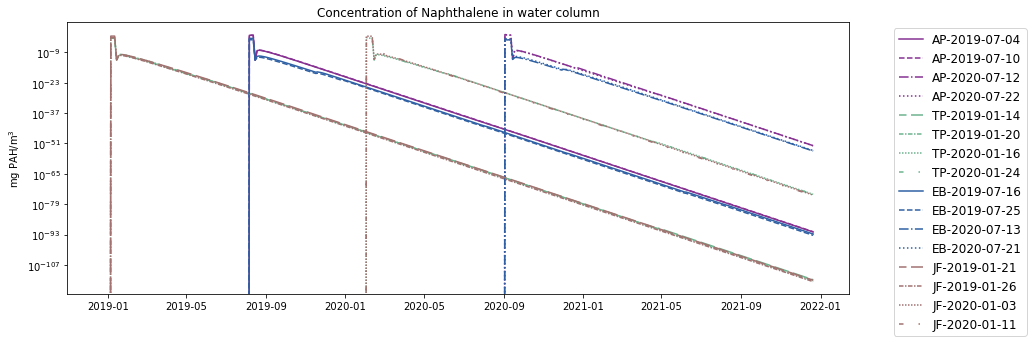

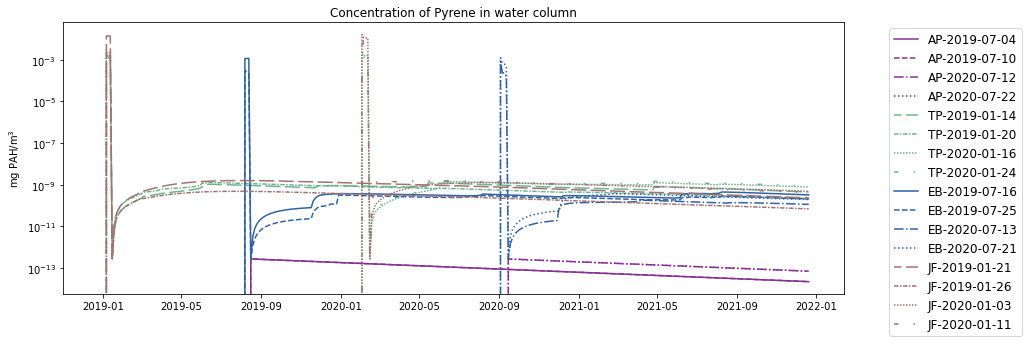

In [8]:
for pah in groups.pahs:
    fig, ax = plt.subplots(figsize = (14,5))
    names = []
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    for scenario, path, i in zip(scenario_datasets,scenario_paths,range(0,len(scenario_datasets))):
        nm = str(path.parent.stem).split(sep='_')
        contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
        contam_tb = contam_tbl.sum(axis=2)
        contam_t = contam_tb.sum(axis=1)
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'
        names.append(scenario_name)
        ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
    ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
    ax.set_ylabel('mg PAH/m$^3$')
    #ax.legend(names, loc='best')
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12); #loc='upper left', 

In [10]:
def compare_scenarios_pelagic_N(bio_group, boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None): 

    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
      (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    
    names = ['control']

    fig, ax = plt.subplots(figsize = (14,3))

    pelagic_control = np.ma.filled(control.variables[bio_group + '_N'][start:end,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=2)
    pelagic_control = pelagic_control.sum(axis=1)
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], control_ratio, 'k', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'
        
        names.append(scenario_name)

        pelagic_oiled = np.ma.filled(scenario.variables[bio_group + '_N'][start:end,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=2) 
        pelagic_oiled = pelagic_oiled.sum(axis=1) 
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t[start:end], ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
    ax.fill_between(scenario.t[start:end], -groups.sensitivity[species], groups.sensitivity[species],
        color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title(species)
    ax.set_ylim([y_min, y_max])
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12); 

In [14]:
def compare_scenarios_benthic_N(bio_group, boxes=groups.salish_sea, start=start, end=end, y_min=None, y_max=None): 

    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
      (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    
    names = ['control']

    fig, ax = plt.subplots(figsize = (14,3))

    pelagic_control = np.ma.filled(control.variables[bio_group + '_N'][start:end,boxes], np.nan)
    pelagic_control = pelagic_control.sum(axis=1)
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t[start:end], control_ratio, 'k', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'
        
        names.append(scenario_name)

        pelagic_oiled = np.ma.filled(scenario.variables[bio_group + '_N'][start:end,boxes], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=1) 
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t[start:end], ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
    ax.fill_between(scenario.t[start:end], -groups.sensitivity[species], groups.sensitivity[species],
        color='grey', alpha=0.3, label='Model Sensitivity')
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.set_title(species)
    ax.set_ylim([y_min, y_max])
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12); 

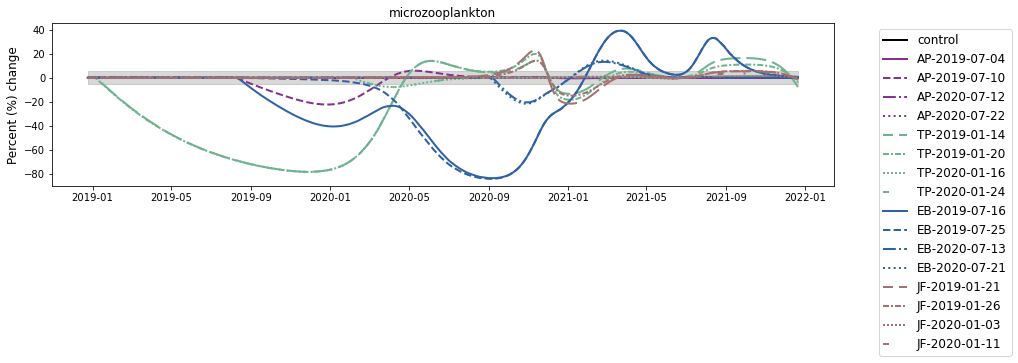

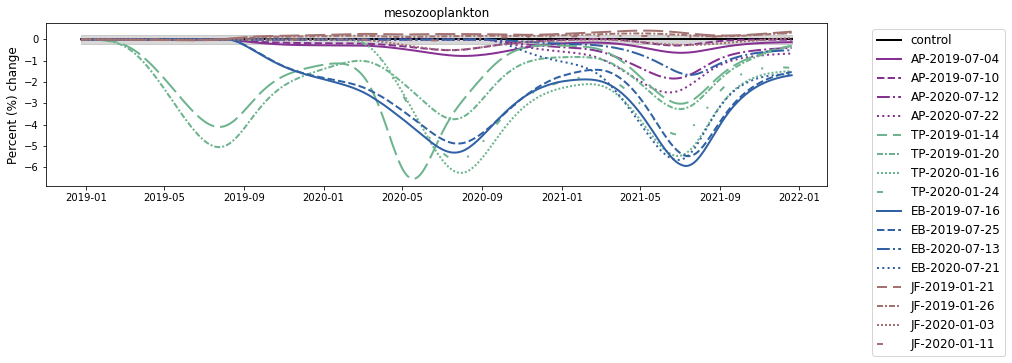

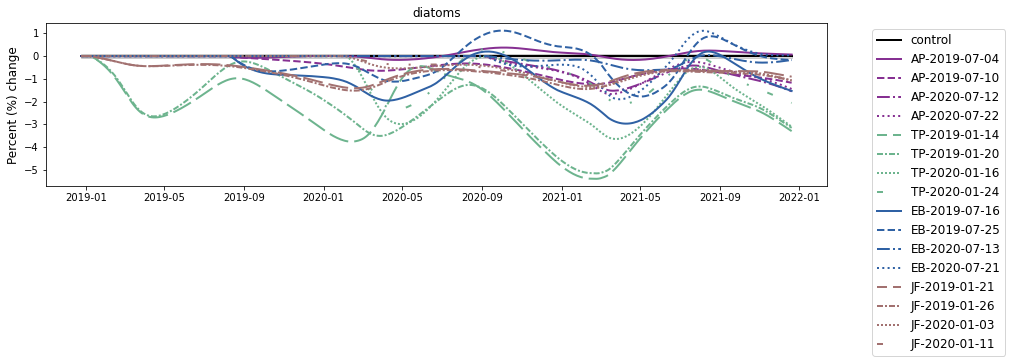

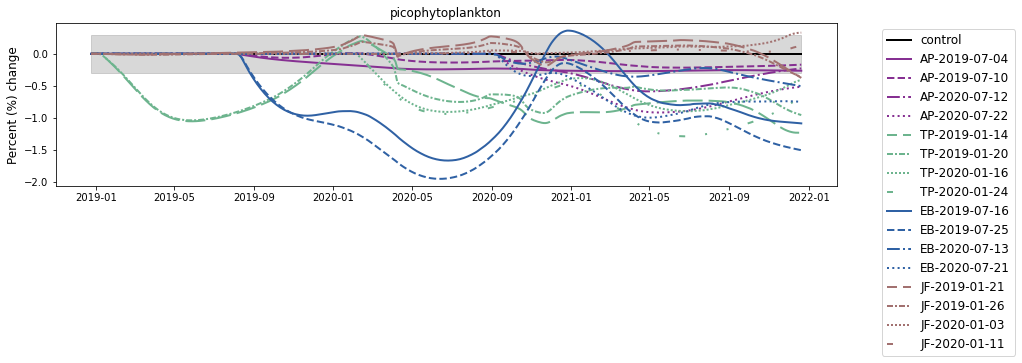

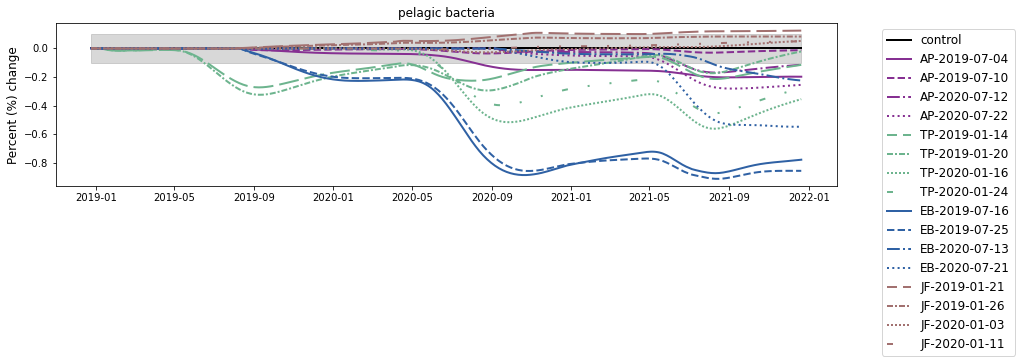

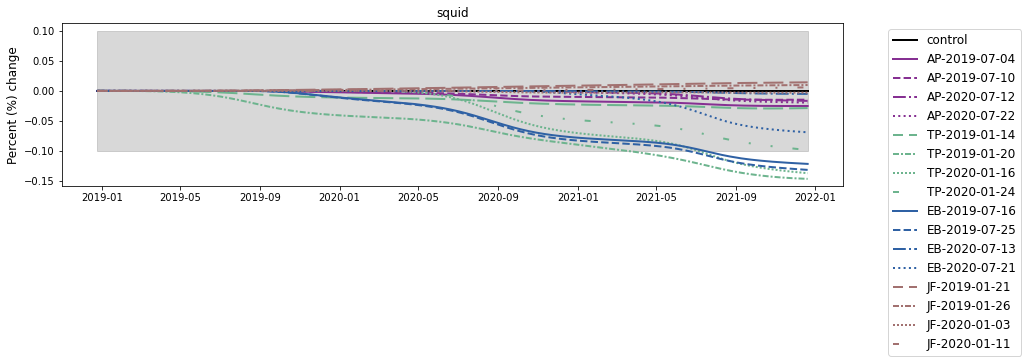

In [12]:
for species in groups.planktonic:
    compare_scenarios_pelagic_N(groups.planktonic[species])

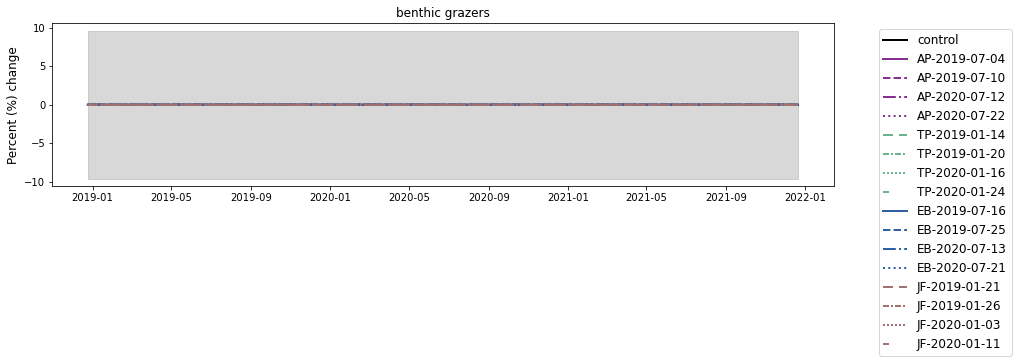

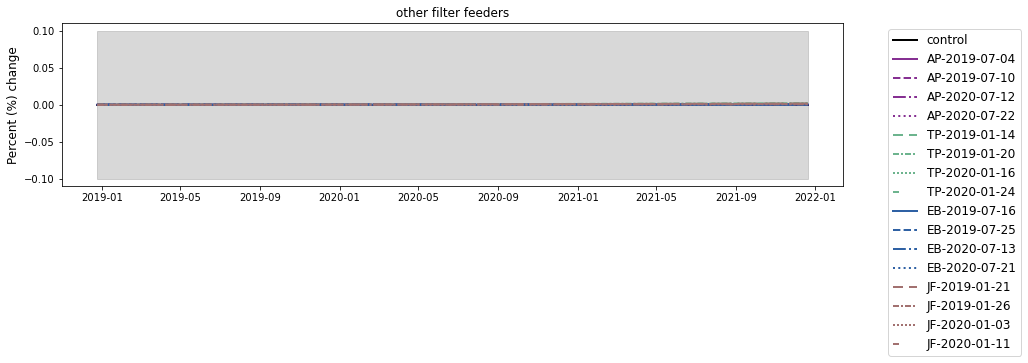

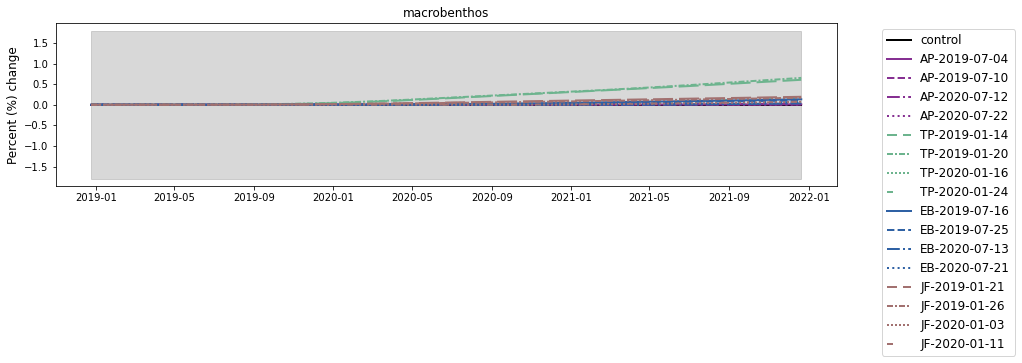

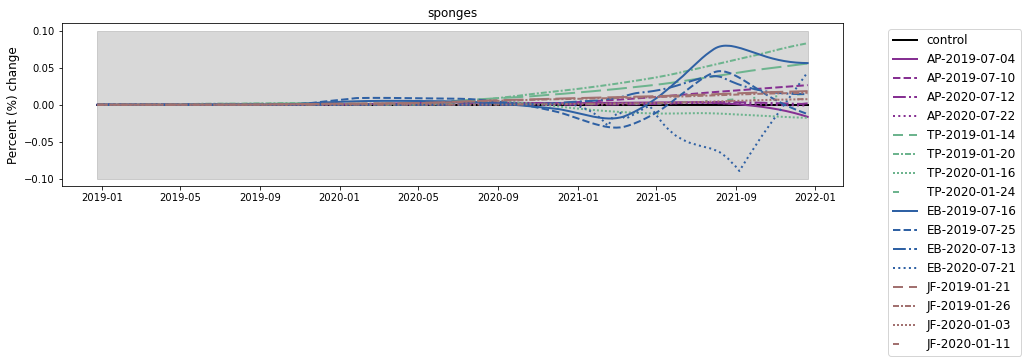

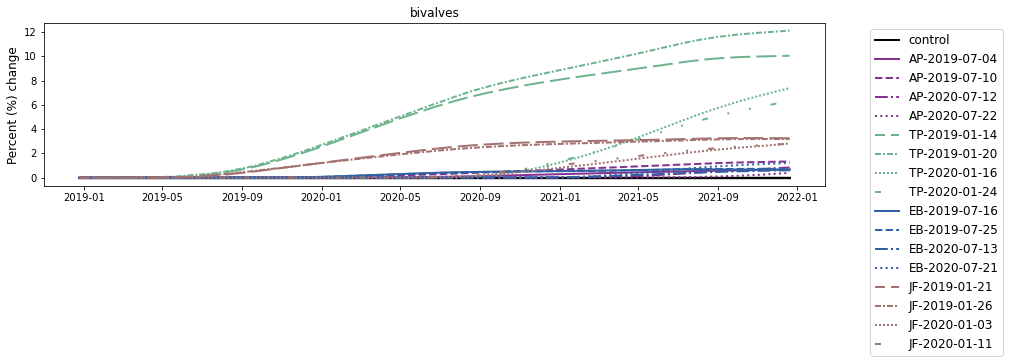

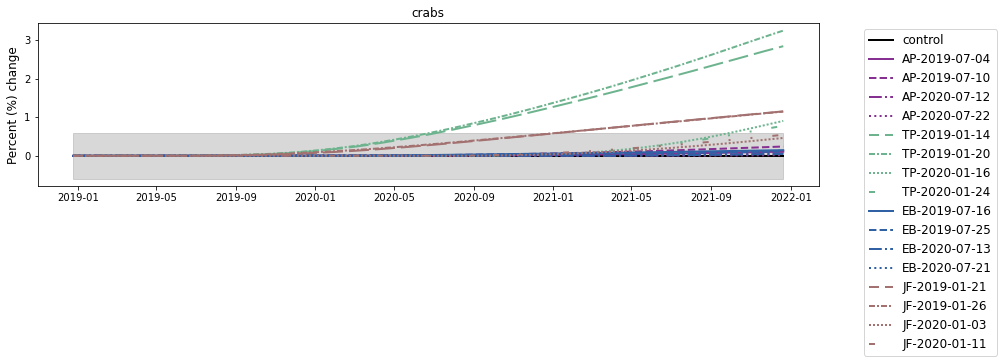

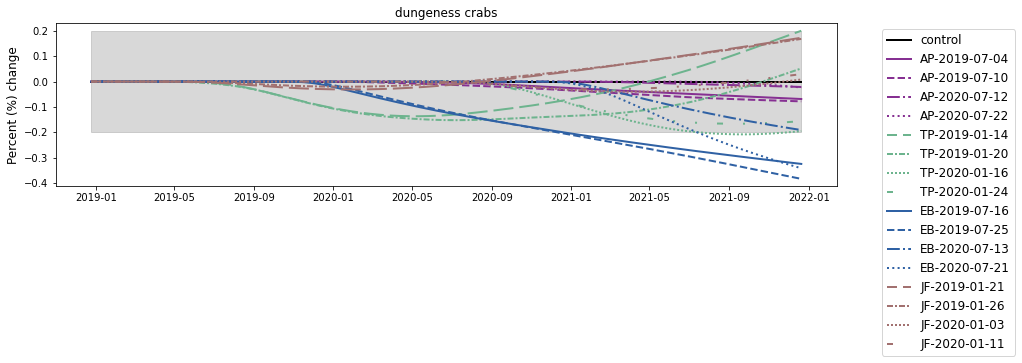

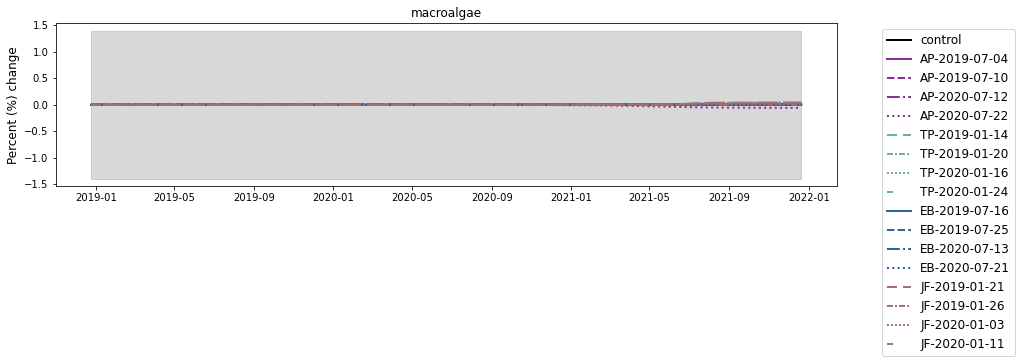

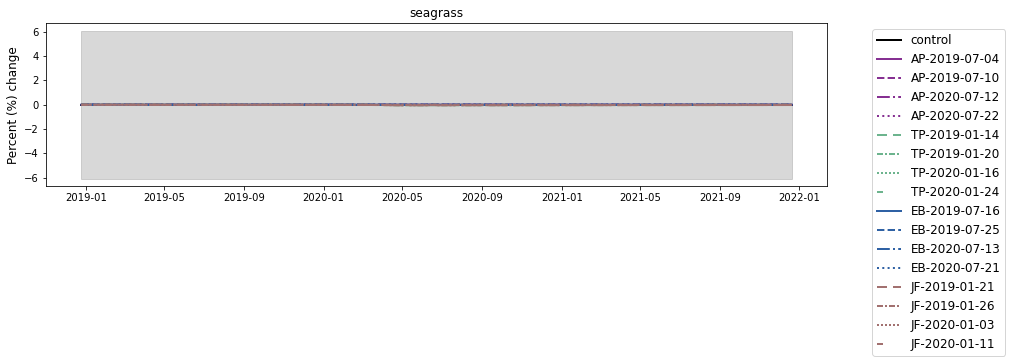

In [15]:
for species in groups.benthos:
    compare_scenarios_benthic_N(groups.benthos[species])

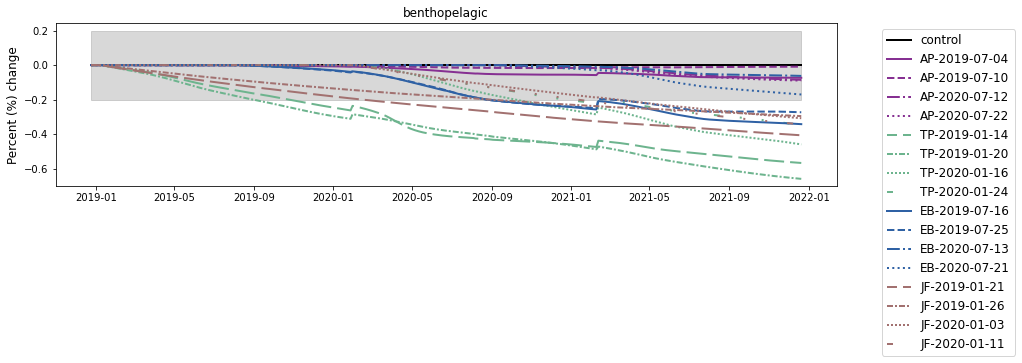

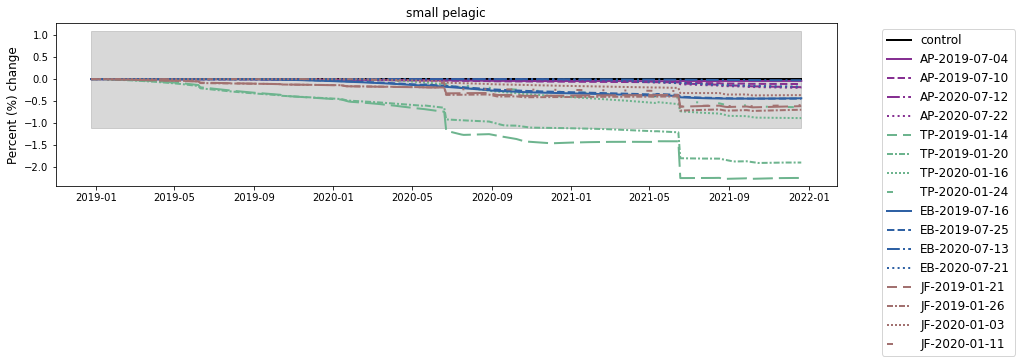

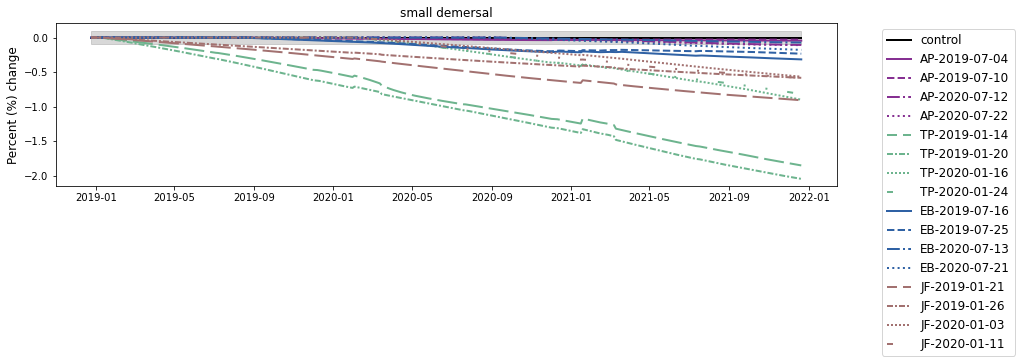

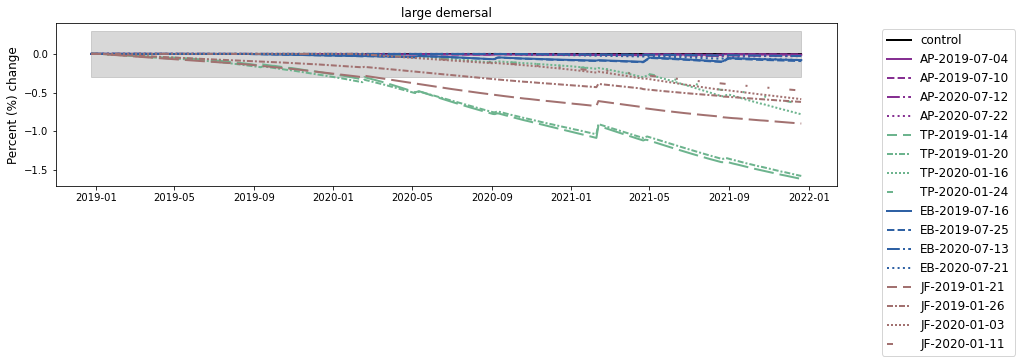

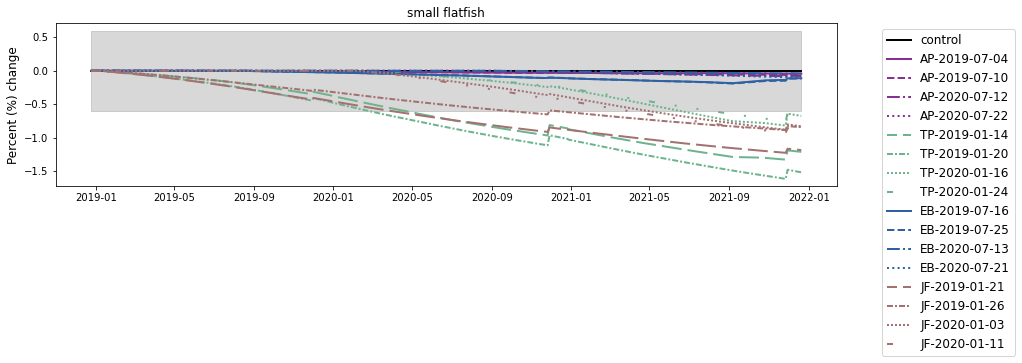

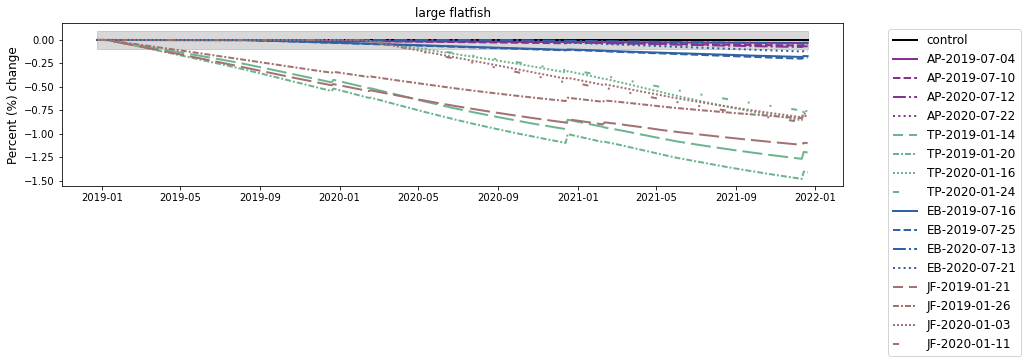

In [13]:
for species in groups.other_fish:
    compare_scenarios_pelagic_N(groups.other_fish[species])